# **Reinforcement Learning**
<img align="right" src="https://vitalflux.com/wp-content/uploads/2020/12/Reinforcement-learning-real-world-example.png">

- In reinforcement learning, your system learns how to interact intuitively with the environment by basically doing stuff and watching what happens.

if you need the last version of gym use block of code below:

```sh
!pip uninstall gym -y
!pip install gym
```
<br>

And here is gymnasium version:

```python
gymnasium.__version__
```
1.2.0

<br>

<center><img src="https://media.tenor.com/zOoVaNGp6IsAAAAd/mario-game.gif"><center>

In [ ]:
# !pip install -U gym==0.25.2
!pip install swig
!pip install gymnasium[atari]
!pip install gymnasium[box2d]
!pip install gymnasium[accept-rom-license]
# !pip install autorom[accept-rom-license]

In [5]:
from collections import deque
import random
import copy
from tqdm.auto import tqdm
from collections import defaultdict, deque, namedtuple
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from IPython.core.display import HTML
from base64 import b64encode
from gym.wrappers import record_video, record_episode_statistics
from gym.wrappers import RecordVideo, RecordEpisodeStatistics, TimeLimit

import torch
from torch import nn

import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

import warnings
warnings.filterwarnings('ignore')

In [4]:
def display_video(episode=0, video_width=600):
    """
    Displays a video from a specified episode with customizable width.

    Args:
        episode (int): The episode number to load the video for. Defaults to 0.
        video_width (int): The width of the video player in pixels. Defaults to 600.

    Returns:
        IPython.display.HTML: An HTML video element that can be rendered in Jupyter notebooks.

    Note:
        - The function expects video files to be in './video/' directory with naming format 'rl-video-episode-{N}.mp4'
        - Videos are base64 encoded and embedded directly in the HTML for display
    """
    # Construct the path to the video file based on episode number
    video_path = f"./video/rl-video-episode-{episode}.mp4"

    # Read the video file as binary data
    video_file = open(video_path, "rb").read()

    # Encode the binary video data as base64 string
    decoded = b64encode(video_file).decode()

    # Create a data URL for the video
    video_url = f"data:video/mp4;base64,{decoded}"

    # Return an HTML video element with the embedded video
    return HTML(f"""<video width="{video_width}"" controls><source src="{video_url}"></video>""")

def create_env(name, render_mode=None, record=False, eps_record=50, video_folder='./video'):
    """
    Creates and configures a Gym environment with optional video recording and statistics tracking.

    Args:
        name (str): Name of the Gym environment to create (e.g., 'CartPole-v1')
        render_mode (str): Rendering mode - "human", "rgb_array", or "ansi".
                                Defaults to None for faster training, for recording use "rgb_array"
        record (bool): Whether to record videos of the environment. Defaults to False
        eps_record (int): Record a video every N episodes (when record=True). Defaults to 50
        video_folder (str): Directory to save recorded videos. Defaults to './video'

    Returns:
        gym.Env: Configured Gym environment wrapped with recording and statistics tracking

    Note:
        - When record=True, videos will be saved in the specified folder with automatic naming
        - The environment is always wrapped with episode statistics tracking
    """
    # Create base Gym environment with specified render mode
    env = gym.make(name, render_mode=render_mode)

    # Optionally wrap environment with video recorder
    if record:
        # Record video every eps_record episodes (trigger function)
        env = RecordVideo(env, video_folder=video_folder,
                         episode_trigger=lambda x: x % eps_record == 0)

    # Always wrap environment with episode statistics tracker
    env = RecordEpisodeStatistics(env)

    return env

## **Deep Q Network**
Deep Q-learning, is considered the most modern reinforcement learning technique. we will develop various deep Q-network models step by step and apply them to solve several reinforcement learning problems.

You will recall that Function Approximation (FA) approximates the state space using a set of features generated from the original states. Deep Q-Networks (DQNs) are very similar to FA with neural networks, but they use neural networks to map the states to action values directly instead of using a set of generated features as media.

In Deep Q-learning, a neural network is trained to output the appropriate Q(s,a) values for each action given the input state, s. The action, a, of the agent is chosen based on the output Q(s,a) values following the epsilon-greedy policy.

<center><img src="https://www.baeldung.com/wp-content/uploads/sites/4/2023/04/dql-vs-ql-1.png"></center>

<br>

**Here is how Q-learning works:**

Q-learning is an off-policy learning algorithm. It updates the Q-function based on the following equation:

<br>

$$
\large \textit{Q-learning algorithm}
$$

$$
\\ \large Q(s, a) ← Q(s, a) + \alpha[r + \gamma \underset{a'}{max} Q(s', a') - Q(s, a)]
$$

<br>

>$
 \textit{ s' is the resulting state after taking action a, in state, s;} \\
 \textit{ r is the associated reward;} \\
 \textit{ α is the learning rate; and γ is the discount factor}
$

<br>

Also, $\underset{a'}{max} Q(s', a')$, means that the behavior policy($b(a|s)$) is greedy, where the highest Q-value among those in state $s'$ is selected to generate learning data. In Q-learning, actions are taken on the basis of the **epsilon-greedy policy**. DQNs learn to minimize the following error term:

<br>


$$
\large \delta = r + \gamma \underset{a'}{max} Q(s') - Q(s)
$$

<br>

Now, the goal becomes one of finding the optimal network model to best approximate the state-value function, $Q(s, a)$, for each possible action. The loss function we are trying to minimize in this case is similar to that in a regression problem, which is the **mean squared error($MSE$)** between the actual value and the estimated value.

Deep Q-learning approximates the state values with a more direct model, a neural network, than using a set of intermediate artificial features. Given one step, where an old state transfers to a new state by taking an action and receives a reward, training the DQN involves the following phases:

- Use the neural network model to estimate the Q values of the **old** state.

- Use the neural network model to estimate the Q values of the **new** state.
- Update the target Q value for the action using the reward and the new Q values, as in $\delta = r + \gamma \underset{a'}{max} Q(s') - Q(s)$
- Note that if it is a terminal state, the target Q value is updated as $r$, since there is no state after that.
- Train the neural network model with the old state as the input, and the target Q values as the output.

It updates the weights for the network via gradient descent and can predict the Q values given a state.

DQN dramatically reduces the number of states to learn, where learning millions of states is not feasible in the TD method. Moreover, it directly maps the input state to the Q values, and does not require any additional functions to generate artificial features.

## **Optimizer**

To use `torch.optim` you have to construct an optimizer object that will hold the current state and will update the parameters based on the computed gradients.

**>>> Note: step should be called after validate() whereas in pytorch lightning `configure_optimizers` will handle it for us**
- this is very useful when one wants to specify per-layer learning rates:
    ```python
    optim.SGD([
                {'params': model.base.parameters()},
                {'params': model.classifier.parameters(), 'lr': 1e-3}
            ], lr=1e-2, momentum=0.9)
    ```
  This means that `model.base’s` parameters will use the default learning rate of $10^{-2}$, `model.classifier’s` parameters will use a learning rate of $10^{-3}$, and a momentum of 0.9 will be used for all parameters.

<br>

**How to adjust learning rate**

`torch.optim.lr_scheduler` provides several methods to adjust the learning rate based on the number of epochs.
- `torch.optim.lr_scheduler.ReduceLROnPlateau` allows dynamic learning rate reducing based on some validation measurements.

    ```python
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = ExponentialLR(optimizer, gamma=0.9)

    for epoch in range(20):
        for input, target in dataset:
            optimizer.zero_grad()
            output = model(input)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
        scheduler.step()
    ```
Most learning rate schedulers can be called back-to-back (also referred to as chaining schedulers). The result is that each scheduler is applied one after the other on the learning rate obtained by the one preceding it.
    ```python
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler1 = ExponentialLR(optimizer, gamma=0.9)
    scheduler2 = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

    for epoch in range(20):
        for input, target in dataset:
            optimizer.zero_grad()
            output = model(input)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
        scheduler1.step()
        scheduler2.step()
    ```

- `torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma=0.1, last_epoch=- 1, verbose=False)`

    ```python
    # Assuming optimizer uses lr = 0.05 for all groups
    # lr = 0.05     if epoch < 30
    # lr = 0.005    if 30 <= epoch < 60
    # lr = 0.0005   if 60 <= epoch < 90
    # ...
    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
    for epoch in range(100):
        train(...)
        validate(...)
        scheduler.step()
    ```

In [10]:
class ReplayBuffer():
    """
    A fixed-size buffer that stores agent experiences for replay.

    Attributes:
        capacity (int): Maximum number of experiences the buffer can hold.
        buffer (deque): A double-ended queue to store experiences with a maximum length of `capacity`.
    """
    def __init__(self, capacity):
        """
        Initialize the ReplayBuffer.

        Args:
            capacity (int): The maximum number of experiences to store in the buffer.
        """
        self.capacity = capacity  # Maximum size of the buffer
        self.buffer = deque(maxlen=self.capacity)  # Create a deque with a fixed maximum size
        self.position = 0

    def __len__(self):
        """
        Return the current number of experiences stored in the buffer.

        Returns:
            int: Number of elements in the buffer.
        """
        return len(self.buffer)

    def append(self, experience):
        """
        Add a new experience to the buffer.

        If the buffer is full, the oldest experience is automatically removed.

        Args:
            experience (tuple): A single experience (state, action, reward, next_state, done).
        """

        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            # Replace the oldest experience
            self.buffer[self.position] = experience

        self.position = (self.position + 1) % self.capacity


    def sample(self, batch_size):
        """
        Sample a random batch of experiences from the buffer.

        Args:
            batch_size (int): The number of experiences to sample.

        Returns:
            list: A list of randomly sampled experiences from the buffer.
        """
        indices = np.random.choice(len(self.buffer), batch_size)
        return [self.buffer[idx] for idx in indices]

In [32]:
# Define the neural network architecture
class DeepNetwork(nn.Module):
    def __init__(self, n_state, n_action, n_hidden=64, activation='relu'):
        """
        Initialize the deep neural network.

        Parameters:
            n_state (int): Number of input features (state dimensions).
            n_action (int): Number of possible actions (output dimensions).
            n_hidden (int): Number of neurons in the hidden layers (default: 64).
            activation (str): relu for  Relu(), otherwise SELU().
        """
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_state, n_hidden * 2),                                        # Input layer to first hidden layer
            nn.ReLU() if activation == 'relu' else nn.SELU(),                        # Activation function
            nn.Linear(n_hidden * 2, n_hidden * 4),                                   # Second hidden layer
            nn.ReLU() if activation == 'relu' else nn.SELU(),                        # Activation function
            nn.Linear(n_hidden * 4, n_hidden),                                       # Third hidden layer
            nn.ReLU() if activation == 'relu' else nn.SELU(),                        # Activation function
            nn.Linear(n_hidden, n_action)                                            # Output layer for action values
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """
        Initialize weights for Linear layers
        """
        for m in self.model:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0.1)  # Small positive bias to prevent dead neurons

    def forward(self, state):
        """
        Forward pass through the network.

        Parameters:
            state (tensor): Input state tensor.

        Returns:
            tensor: Output Q-values for each action.
        """
        return self.model(state)

In [33]:
# Define the DQN class
class DQN():
    def __init__(self, env, n_hidden=64, lr=0.01, optStep=50, optgamma=0.9, activation='relu'):
        """
        Initialize the Deep Q-Network (DQN).

        Parameters:
            env (gym.Env): Gym environment object.
            n_hidden (int): Number of hidden units for the network (default: 50).
            lr (float): Learning rate for the optimizer (default: 0.05).
            optStep (float): Learning rate decay factor for the scheduler (default: 0.9).
            activation (str): relu for  Relu(), otherwise SELU().
        """
        device = "cuda" if torch.cuda.is_available() else "cpu"
        # Number of actions and states
        self.n_action = env.action_space.n
        self.n_state = env.observation_space.shape[0]

        # Loss function for training (Huber loss by default)
        self.criterion = nn.SmoothL1Loss()
        # self.criterion = nn.MSELoss()  # Optionally, use Mean Squared Error loss

        # Initialize the primary and target networks
        self.model = DeepNetwork(self.n_state, self.n_action, n_hidden, activation=activation).to(device)
        self.target_model = copy.deepcopy(self.model)  # Deep copy to ensure separate networks

        # Optimizer for training the primary network
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

        # Learning rate scheduler for adaptive optimization
        self.schedul = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=optStep, gamma=optgamma)

    def predict(self, state):
        """
        Predict Q-values for the given state using the primary network.

        Parameters:
            state (tensor): Input state tensor.

        Returns:
            tensor: Predicted Q-values.
        """
        with torch.no_grad():  # Disable gradient computation for inference
            return self.model(state)

    def target_predict(self, state):
        """
        Predict Q-values for the given state using the target network.

        Parameters:
            state (tensor): Input state tensor.

        Returns:
            tensor: Predicted Q-values.
        """
        with torch.no_grad():  # Disable gradient computation for inference
            return self.target_model(state)

    def target_update(self):
        """
        Update the target network to match the primary network.
        """
        self.target_model.load_state_dict(self.model.state_dict())

    def update(self, states, actions, q_value):
        """
        Update the primary network by minimizing the loss.

        Parameters:
            states (tensor): Batch of state tensors.
            actions (list): Batch of action indices taken.
            q_value (tensor): Target Q-values for the actions.
        """
        # Forward pass through the network to predict Q-values
        Q_pred = self.model(states)

        # Select Q-values for the taken actions
        Q_pred = Q_pred.gather(1, torch.tensor(actions, dtype=torch.long).unsqueeze(1)).squeeze()

        # Compute loss between predicted and target Q-values
        loss = self.criterion(Q_pred, q_value)

        # Backpropagation and optimization
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [114]:
class Q_learning():
    """
    A Q-learning agent with experience replay.
    """

    def __init__(self, env, network, gamma, n_episode, epsilon=0.3, min_epsilon=0.1,
                 epsilon_decay=0.995, batch_size=512, capacity=10_000, random_play=1000, model_path=None):
        """
        Initialize the Q-learning agent.

        Args:
            env: The environment (OpenAI Gym compatible).
            network: The neural network used for predicting Q-values.
            gamma: Discount factor for future rewards.
            n_episode: Total number of episodes for training.
            epsilon: Initial epsilon for exploration.
            min_epsilon: Minimum epsilon value (to ensure some exploration).
            epsilon_decay: Factor by which epsilon decays after every 50 episodes.
            batch_size: Number of experiences sampled from the replay buffer per update.
            capacity: Replay buffer capacity
            random_play: Number of random experience to fill the buffer.
            model_path: network pretrian models path
        """
        self.device = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available
        self.env = env  # Environment
        self.network = network  # Neural network
        self.n_action = env.action_space.n  # Number of possible actions
        self.gamma = gamma  # Discount factor
        self.n_episode = n_episode  # Total number of episodes
        self.epsilon = epsilon  # Initial epsilon for exploration
        self.min_epsilon = min_epsilon  # Minimum epsilon value
        self.epsilon_decay = epsilon_decay  # Epsilon decay rate
        self.buffer = ReplayBuffer(capacity)  # Replay buffer for experience replay
        self.batch_size = batch_size  # Batch size for training
        self.epi = 0  # Current episode index
        self.capacity = capacity
        self.best_reward = float('-inf')

        # Arrays to track episode lengths and total rewards
        self.length_episode = []   # Number of steps per episode
        self.total_reward_episode = []  # Total reward per episode

        if model_path and os.path.isfile(model_path):
            print('>>> Loading Q-network model...')
            self.load(model_path)
        else:
            print('>>> Pretrain model does not exist...')
            # Ensure the replay buffer is filled with enough samples before training
            with tqdm(total=random_play, desc="Filling replay buffer") as pbar:
                while len(self.buffer) < random_play:
                    current_size = len(self.buffer)
                    self.play()  # Collect more samples
                    new_size = len(self.buffer)
                    pbar.update(new_size - current_size)  # Update progress
                    pbar.set_postfix({"Current": len(self.buffer), "Target": random_play})

    def load(self, path):
        checkpoint = torch.load(path, map_location=self.device)
        self.network.model.load_state_dict(checkpoint['model_state_dict'])
        self.network.target_model.load_state_dict(checkpoint['target_model_state_dict'])
        self.network.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.network.schedul.load_state_dict(checkpoint['lr_sched_state_dict'])


    def test_agent(self, num_test_episodes):
        # Evaluate the agent's performance over a specified number of test episodes
        ep_rets, ep_lens = [], []  # Episode returns and lengths
        epsilon = 0
        for _ in range(num_test_episodes):
            state, _ = self.env.reset()  # Reset the environment
            state = torch.tensor(state, dtype=torch.float32).to(self.device)
            done, rewards, length = False, 0, 0
            while not done:
                action = self.take_action(self.network, state, epsilon, self.n_action)

                state, reward, done, _ = self.env.step(action)
                state = torch.tensor(state, dtype=torch.float32).to(self.device)
                rewards += reward
                length += 1

            ep_rets.append(rewards)  # Record the total reward
            ep_lens.append(length)  # Record the episode length

        print(f"Average reward: {np.mean(ep_rets):.2f} - "
              f"Average length of episodes: {np.mean(ep_lens)}")  # print average reward and length

    def train(self):
        """
        Train the Q-learning agent using experiences from the replay buffer.
        """
        print(">>> Available device: ", self.device)
        pbar = tqdm(range(self.n_episode), desc = "Episode")  # Progress bar for tracking episodes
        for episode in pbar:
            # Play an episode and store experiences in the buffer
            self.play(train=True)

            # Sample a batch from the replay buffer and update the network
            self.update(self.buffer.sample(self.batch_size))
            self.network.schedul.step()

            # Decay epsilon after each episode (but not below minimum)
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

            # Update the target network periodically
            if self.epi % 25 == 0:
                self.network.target_update()

            # Compute and print the average total reward over past 50 completed episodes
            start = episode - 50 if episode > 50 else 0
            avg_tot_reward = np.array(self.total_reward_episode[start:]).mean()

            # Update progress bar description
            pbar.set_postfix({
                "Average reward": f"{avg_tot_reward:.2f}",
                "ε": f"{self.epsilon:.3f}",
                "α Neural Network": f"{self.network.optimizer.param_groups[0]['lr']:.6f}",
                "Reply buffer filling": f"{len(self.buffer) / self.capacity * 100:.2f} %"
            })

            if self.total_reward_episode[self.epi - 1] > self.best_reward:
                self.best_reward = self.total_reward_episode[self.epi - 1]

                torch.save(
                    {
                        'model_state_dict': self.network.model.state_dict(),
                        'target_model_state_dict': self.network.target_model.state_dict(),
                        'optimizer_state_dict': self.network.optimizer.state_dict(),
                        'lr_sched_state_dict': self.network.schedul.state_dict()
                    }, 'model.pth'
                )

        print(f"Best reward: {self.best_reward}")

    def update(self, exp):
        """
        Perform Q-value update for a given batch of experiences.

        Args:
            exp: Batch of experiences (state, action, reward, next_state, done).
        """
        # Unpack experience tuples into separate lists
        states, actions, rewards, next_states, dones = zip(*exp)

        # Convert data to tensors and send to the device
        states = torch.stack(states).to(self.device)
        actions = torch.tensor(actions).to(self.device)
        next_states = torch.stack(next_states).to(self.device)
        rewards = torch.tensor(rewards, device=self.device)
        dones = torch.tensor(dones, dtype=torch.long)

        # Predict Q-values for the current states and next states
        Q = self.network.predict(states).cpu()
        Q_next = (1 - dones) * torch.max(self.network.target_predict(next_states).cpu(), dim=1).values

        # Calculate the TD target, 𝑟 + 𝛾 * 𝑚𝑎𝑥(𝑎′)𝑄(𝑠′). If done then Q_next = 0
        td_target = rewards + self.gamma * Q_next.to(self.device)

        # Update the Q-value for the current state-action pair
        self.network.update(states, actions, td_target)

    def play(self, train=False):
        """
        Play one episode of the environment.

        Args:
            train (bool): If True, updates the replay buffer and tracks episode statistics.
        """
        # Reset the environment at the start of the episode
        state, _ = self.env.reset()
        state = torch.tensor(state, device=self.device)
        length_episode = 0
        total_reward_episode = 0
        done = False  # Flag to indicate if the episode has ended

        while not done:
            # Select an action using the epsilon-greedy policy
            action = self.take_action(self.network, state, self.epsilon, self.n_action)

            # Take the chosen action and observe the next state, reward, and done flag
            next_state, reward, done, _ = self.env.step(action)

            if train:
                # Track the length of the episode (number of steps)
                length_episode+= 1

                # Track the total reward for this episode
                total_reward_episode+= reward

            # Convert next state to tensor
            next_state = torch.tensor(next_state, device=self.device)

            # Store the experience in the replay buffer
            exp = (state, action, reward, next_state, done)
            self.buffer.append(exp)

            # Move to the next state
            state = next_state

        if train:
            # Increment the episode counter
            self.epi += 1
            self.length_episode.append(length_episode)
            self.total_reward_episode.append(total_reward_episode)


    def take_action(self, network, state, epsilon, n_action):
        """
        Select an action using the epsilon-greedy policy.

        Args:
            network: The model used to predict Q-values.
            state: The current state.
            epsilon: The current exploration rate.
            n_action: The total number of possible actions.

        Returns:
            int: The selected action.
        """
        if np.random.random() < epsilon:
            # Exploration: Choose a random action
            return torch.randint(0, n_action, (1,)).item()
        else:
            # Exploitation: Choose the action with the highest Q-value
            Q = network.predict(state)
            return torch.argmax(Q).item()

    def log(self):
        """
        Plot and log the rewards and lengths of episodes over time.
        """
        fig = plt.figure(figsize=(12, 4))

        # Plot total reward per episode
        fig.add_subplot(1, 2, 1)
        plt.plot(self.total_reward_episode)
        plt.title('Episode reward over time')
        plt.xlabel('Episode')
        plt.ylabel('Total reward')

        # Plot episode length over time
        fig.add_subplot(1, 2, 2)
        plt.plot(self.length_episode)
        plt.title('Episode length over time')
        plt.xlabel('Episode')
        plt.ylabel('Length')

        plt.show()

In [89]:
env = create_env("CartPole-v1")
n_hidden = 64
lr = 0.002
net = DQN(env, n_hidden, lr=lr, optgamma=0.99, activation='relu')


gamma = 0.99
n_episode = 2000
epsilon = 0.3
agent = Q_learning(
    env, net, gamma, n_episode, epsilon, epsilon_decay=0.999, batch_size = 512, random_play = 5000
)

The model file do not exist...


Filling replay buffer:   0%|          | 0/5000 [00:00<?, ?it/s]

Available device:  cuda


Episode:   0%|          | 0/2000 [00:00<?, ?it/s]

Best reward: 500.0


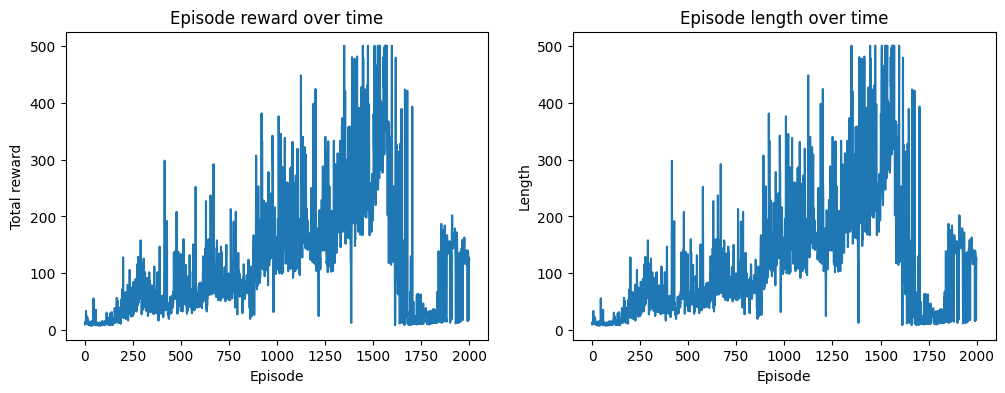

In [90]:
agent.train()
agent.log()

In [104]:
env = create_env("CartPole-v1", render_mode="rgb_array", record=True, eps_record=1)
agent = Q_learning(
    env, net, gamma, n_episode, epsilon, epsilon_decay=0.999, batch_size = 512, random_play = 5000, model_path = "/content/model.pth"
)

Loading Q-network model...


In [107]:
agent.test_agent(3)

Average reward: 411.33 - Average length of episodes: 411.3333333333333


In [109]:
display_video(0)

#### **Lunar Lander Environment**
<img align="right" width="400" src="https://www.gymlibrary.dev/_images/lunar_lander.gif">




<br>

<table>
<tr>
    <td><font size="3">Action Space</td>
    <td><font size="3">Discrete(4)</td>
</tr>
<tr>
    <td><font size="3">Observation Shape</td>
    <td><font size="3">(8,))</td>
</tr>
<tr>
    <td><font size="3">Observation High</td>
    <td><font size="3">[1.5 1.5 5. 5. 3.14 5. 1. 1. ]</td>
</tr>
<tr>
    <td><font size="3">Observation Low</td>
    <td><font size="3">[-1.5 -1.5 -5. -5. -3.14 -5. -0. -0. ]</td>
<tr>
<tr>
    <td><font size="3">Import</td>
    <td><font size="4"><code>gym.make("LunarLander-v2")</code></td>
<tr>


>>> Pretrain model does not exist...


Filling replay buffer:   0%|          | 0/5000 [00:00<?, ?it/s]

>>> Available device:  cuda


Episode:   0%|          | 0/1000 [00:00<?, ?it/s]

Best reward: 267.43012574874757


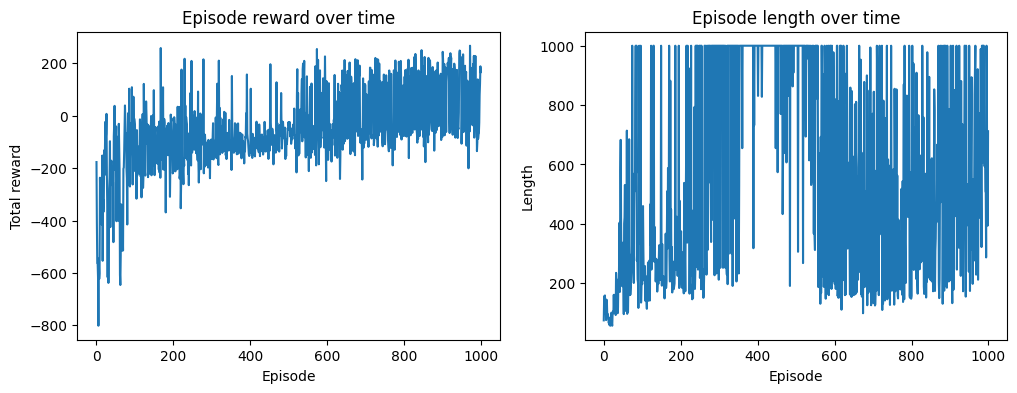

In [116]:
env = create_env("LunarLander-v3", render_mode=None)
n_hidden = 64
lr = 0.002
net = DQN(env, n_hidden, lr=lr, optgamma=0.99, activation='relu')


gamma = 0.99
n_episode = 1000
epsilon = 0.3
agent = Q_learning(
    env, net, gamma, n_episode, epsilon, epsilon_decay=0.997, batch_size = 512, random_play = 5000
)

agent.train()
agent.log()

In [117]:
env = create_env("LunarLander-v3", render_mode="rgb_array", record=True, eps_record=1)
agent = Q_learning(
    env, net, gamma, n_episode, epsilon, epsilon_decay=0.999, batch_size = 512, random_play = 5000, model_path = "/content/model.pth"
)

agent.test_agent(3)

>>> Loading Q-network model...
Average reward: 176.18 - Average length of episodes: 528.3333333333334


In [121]:
display_video(2)

## **Update the Replay Buffer for Prioritization**
- alpha($\alpha$): Controls the degree of prioritization:
    - $\alpha = 0$ : Uniform sampling (no prioritization).
    - $\alpha = 1$ : Full prioritization (experiences with higher TD errors are much more likely to be sampled).


$$
\text{priority} = (|td\_error| + 1e{-5})^{\alpha}
$$

- Normalize priorities:

$$
\text{probabilities} = \frac{\text{priorities}}{\text{sum of all priorities}}
$$

> This converts priorities into probabilities for sampling.

- Sampling Weights:
    - Normalization ensures numerical stability by dividing all weights by the maximum weight.

$$
\text{weights} = \left(\frac{1}{P(i)}\right)^\beta
$$

> where $P(i)$ is the probability of sampling an experience.


In [123]:
class PrioritizedReplayBuffer():
    def __init__(self, capacity, alpha=0.6):
        """
        Initialize a prioritized replay buffer.

        Parameters:
            capacity (int): Maximum number of experiences to store.
            alpha (float): Degree of prioritization (0 = uniform sampling, 1 = full prioritization).
        """
        self.capacity = capacity
        self.buffer = []
        self.priorities = []
        self.alpha = alpha
        self.position = 0  # Index to overwrite old experiences

    def append(self, experience, td_error):
        """
        Add an experience to the buffer with its priority based on TD error.

        Parameters:
            experience (tuple): (state, action, reward, next_state, done).
            td_error (float): Temporal difference error to calculate priority.
        """
        priority = (abs(td_error) + 1e-5) ** self.alpha  # Add small constant for stability

        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
            self.priorities.append(priority)
        else:
            # Replace the oldest experience
            self.buffer[self.position] = experience
            self.priorities[self.position] = priority

        self.position = (self.position + 1) % self.capacity

    def __len__(self):
        """
        Return the current number of experiences stored in the buffer.

        Returns:
            int: Number of elements in the buffer.
        """
        return len(self.buffer)

    def sample(self, batch_size, beta=0.4):
        """
        Sample a batch of experiences based on priorities.

        Parameters:
            batch_size (int): Number of samples to return.
            beta (float): Importance-sampling weight factor (0 = no correction, 1 = full correction).

        Returns:
            batch (list): Sampled experiences.
            weights (ndarray): Importance sampling weights for each sample.
            indices (list): Indices of the sampled experiences for updating priorities.
        """
        priorities = np.array(self.priorities)
        probabilities = priorities / priorities.sum()  # Normalize priorities to probabilities

        indices = np.random.choice(len(self.buffer), batch_size, p=probabilities)
        batch = [self.buffer[idx] for idx in indices]

        # Importance-sampling weights
        total_samples = len(self.buffer)
        weights = (total_samples * probabilities[indices]) ** (-beta)
        weights /= weights.max()  # Normalize for stability

        return batch, weights, indices

    def update_priorities(self, indices, td_errors):
        """
        Update the priorities of specific experiences based on new TD errors.

        Parameters:
            indices (list): Indices of experiences to update.
            td_errors (list): Updated TD errors for those experiences.
        """
        for idx, td_error in zip(indices, td_errors):
            self.priorities[idx] = (abs(td_error) + 1e-5) ** self.alpha

    def __getitem__(self, indices):
        """
        Retrieve experiences and importance sampling weights for given indices.

        Parameters:
            indices (int or list or slice): Indices of experiences to retrieve.

        Returns:
            batch (list): Retrieved experiences.
            weights (ndarray): Importance sampling weights for each sample.
            indices (list): Indices of the retrieved experiences for updating priorities.
        """
        if isinstance(indices, int):  # Single index
            indices = [indices]

        # Handle slices
        if isinstance(indices, slice):
            indices = list(range(len(self.buffer))[indices])

        priorities = np.array(self.priorities)
        probabilities = priorities / priorities.sum()  # Normalize priorities to probabilities

        batch = [self.buffer[idx] for idx in indices]

        # Importance-sampling weights
        total_samples = len(self.buffer)
        weights = (total_samples * probabilities[indices]) ** (-1.0)  # Use full correction
        weights /= weights.max()  # Normalize for stability

        return batch, weights, indices

In [ ]:
class DeepNetwork(nn.Module):
    """
    A deep neural network for approximating Q-values.
    """

    def __init__(self, n_state, n_action, n_hidden=64):
        """
        Initialize the network.

        Args:
            n_state (int): Dimension of the state space.
            n_action (int): Number of possible actions.
            n_hidden (int): Number of hidden units in the layers.
        """
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_state, n_hidden * 2),
            nn.ReLU(),
            nn.Linear(n_hidden * 2, n_hidden * 4),
            nn.ReLU(),
            nn.Linear(n_hidden * 4, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_action)
        )

    def forward(self, state):
        """
        Forward pass through the network.

        Args:
            state (Tensor): Input state.

        Returns:
            Tensor: Output Q-values for each action.
        """
        return self.model(state)


class DQN():
    """
    Deep Q-Network (DQN) implementation.
    """

    def __init__(self, env, n_hidden=50, lr=0.05, optStep=0.9):
        """
        Initialize the DQN agent.

        Args:
            env: OpenAI Gym environment.
            n_hidden (int): Number of hidden units in the neural network.
            lr (float): Learning rate for the optimizer.
            optStep (float): Step size factor for learning rate scheduler.
        """
        self.n_action = env.action_space.n  # Number of possible actions
        self.n_state = env.observation_space.shape[0]  # Dimension of state space
        self.criterion = nn.SmoothL1Loss()  # Huber loss for stability
        # self.criterion = nn.MSELoss()  # Uncomment to use mean squared error loss
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # Initialize the primary and target networks
        self.model = DeepNetwork(self.n_state, self.n_action, n_hidden).to(self.device)
        self.target_model = copy.deepcopy(self.model)

        # Set up the optimizer and learning rate scheduler
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)
        self.schedul = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=50, gamma=optStep)

    def predict(self, state):
        """
        Predict Q-values for the given state using the primary network.

        Args:
            state (Tensor): Input state.

        Returns:
            Tensor: Predicted Q-values.
        """
        with torch.no_grad():
            return self.model(state)

    def weighted_l1_loss(self, predictions, targets, weights):
        """
        Compute the weighted L1 loss.

        Args:
            predictions (Tensor): Predicted Q-values.
            targets (Tensor): Target Q-values.
            weights (Tensor): Importance-sampling weights.

        Returns:
            Tensor: Weighted L1 loss.
        """
        # Calculate the element-wise L1 loss
        l1_loss = torch.abs(predictions - targets)
        # Apply weights to the loss and return the mean
        return torch.mean(weights * l1_loss)

    def target_predict(self, state):
        """
        Predict Q-values using the target network.

        Args:
            state (Tensor): Input state.

        Returns:
            Tensor: Predicted Q-values.
        """
        with torch.no_grad():
            return self.target_model(state)

    def target_update(self):
        """
        Update the target network by copying weights from the primary network.
        """
        self.target_model.load_state_dict(self.model.state_dict())

    def update(self, states, actions, q_value, weights):
        """
        Update the primary network using a batch of experiences.

        Args:
            states (Tensor): Batch of states.
            actions (Tensor): Batch of actions taken.
            q_value (Tensor): Target Q-values.
            weights (Tensor): Importance-sampling weights.
        """
        # Predict Q-values for the batch of states
        Q_pred = self.model(states)
        # Extract Q-values corresponding to the taken actions
        Q_pred = Q_pred.gather(1, torch.tensor(actions, dtype=torch.long).unsqueeze(1)).squeeze()
        # Compute the loss using weighted L1 loss
        loss = self.weighted_l1_loss(Q_pred, q_value, weights)

        # Perform backpropagation and optimization step
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [130]:
class Q_learningPrioritized():
    """
    A Q-learning agent with experience replay.
    """

    def __init__(self, env, network, gamma, n_episode, epsilon=0.3, min_epsilon=0.05,
                 epsilon_decay=0.995, batch_size=512, playUpdate=False,
                 capacity=10_000, random_play=1000, model_path=None):
        """
        Initialize the Q-learning agent.

        Args:
            env: The environment (OpenAI Gym compatible).
            network: The neural network used to predict and update Q-values.
            gamma: Discount factor for future rewards.
            n_episode: Total number of episodes for training.
            epsilon: Initial epsilon for exploration.
            min_epsilon: Minimum epsilon value (to ensure some exploration).
            epsilon_decay: Factor by which epsilon decays after every 50 episodes.
            batch_size: Number of experiences sampled from the replay buffer per update.
            playUpdate: Whether to play and update in real-time during training.
            capacity: Replay buffer capacity
            random_play: Number of random experience to fill the buffer.
            model_path: network pretrian models path
        """
        self.device = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available

        # Environment and agent parameters
        self.env = env
        self.network = network
        self.n_action = env.action_space.n  # Number of possible actions
        self.gamma = gamma  # Discount factor for rewards
        self.n_episode = n_episode  # Total number of episodes
        self.epsilon = epsilon  # Initial exploration rate
        self.min_epsilon = min_epsilon  # Minimum exploration rate
        self.epsilon_decay = epsilon_decay  # Rate at which exploration decreases
        self.buffer = PrioritizedReplayBuffer(capacity)  # Replay buffer for experience storage
        self.batch_size = batch_size  # Number of samples to train on each iteration
        self.epi = 0  # Current episode index
        self.capacity = capacity
        self.best_reward = float('-inf')

        # Metrics to track training progress
        self.length_episode = []   # Track steps per episode
        self.total_reward_episode = []  # Track rewards per episode
        self.playUpdate = playUpdate  # Real-time update flag

        # Load pretrain model, if any..
        if model_path and os.path.isfile(model_path):
            print('>>> Loading Q-network model...')
            self.load(model_path)
        else:
            print('>>> Pretrain model does not exist...')
            # Ensure the replay buffer is filled with enough samples before training
            with tqdm(total=random_play, desc="Filling replay buffer") as pbar:
                while len(self.buffer) < random_play:
                    current_size = len(self.buffer)
                    self.play()  # Collect more samples
                    new_size = len(self.buffer)
                    pbar.update(new_size - current_size)  # Update progress
                    pbar.set_postfix({"Current": len(self.buffer), "Target": random_play})

    def load(self, path):
        checkpoint = torch.load(path, map_location=self.device)
        self.network.model.load_state_dict(checkpoint['model_state_dict'])
        self.network.target_model.load_state_dict(checkpoint['target_model_state_dict'])
        self.network.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.network.schedul.load_state_dict(checkpoint['lr_sched_state_dict'])


    def test_agent(self, num_test_episodes):
        # Evaluate the agent's performance over a specified number of test episodes
        ep_rets, ep_lens = [], []  # Episode returns and lengths
        epsilon = 0
        for _ in range(num_test_episodes):
            state, _ = self.env.reset()  # Reset the environment
            state = torch.tensor(state, dtype=torch.float32).to(self.device)
            done, rewards, length = False, 0, 0
            while not done:
                action = self.take_action(self.network, state, epsilon, self.n_action)

                state, reward, done, _ = self.env.step(action)
                state = torch.tensor(state, dtype=torch.float32).to(self.device)
                rewards += reward
                length += 1

            ep_rets.append(rewards)  # Record the total reward
            ep_lens.append(length)  # Record the episode length

        print(f"Average reward: {np.mean(ep_rets):.2f} - "
              f"Average length of episodes: {np.mean(ep_lens)}")  # print average reward and length

    def train(self):
        """
        Train the Q-learning agent using experiences from the replay buffer.
        """
        print(f">>> Available device: {self.device} - Highest possible score: {self.env.spec.reward_threshold}")
        pbar = tqdm(range(self.n_episode), desc = "Episode")  # Progress bar for tracking episodes
        for episode in pbar:
            # Play an episode and store experiences in the buffer
            self.play(train=True)

            # Sample experiences from the replay buffer and update the Q-values
            exp, weights, indices = self.buffer.sample(self.batch_size)
            self.update(exp, weights, indices)
            self.network.schedul.step()

            # Decay epsilon after each episode (but not below minimum)
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

            # Update the target network periodically
            if self.epi % 25 == 0:
                self.network.target_update()

            # Compute and print the average total reward over past 50 completed episodes
            start = episode - 50 if episode > 50 else 0
            avg_tot_reward = np.array(self.total_reward_episode[start:]).mean()

            # Update progress bar description
            pbar.set_postfix({
                "Average reward": f"{avg_tot_reward:.2f}",
                "ε": f"{self.epsilon:.3f}",
                "α Neural Network": f"{self.network.optimizer.param_groups[0]['lr']:.6f}",
                "Reply buffer filling": f"{len(self.buffer) / self.capacity * 100:.2f} %"
            })

            if self.total_reward_episode[self.epi - 1] > self.best_reward:
                self.best_reward = self.total_reward_episode[self.epi - 1]

                torch.save(
                    {
                        'model_state_dict': self.network.model.state_dict(),
                        'target_model_state_dict': self.network.target_model.state_dict(),
                        'optimizer_state_dict': self.network.optimizer.state_dict(),
                        'lr_sched_state_dict': self.network.schedul.state_dict()
                    }, 'model.pth'
                )

        print(f"Best reward: {self.best_reward}")

    def update(self, exp, weights, indices, play=False):
        """
        Perform Q-value update for a batch of experiences.

        Args:
            exp: A batch of experiences (states, actions, rewards, next_states, done, td_error).
            weights: Importance-sampling weights for prioritization.
            indices: Indices of the sampled experiences in the replay buffer.
            play: Whether the update is happening during a play.
        """
        # Unpack the batch of experiences
        states, actions, rewards, next_states, dones, td_errors = zip(*exp)

        # Convert experiences to tensors and send to the appropriate device
        states = torch.stack(states).to(self.device)
        actions = torch.tensor(actions).to(self.device)
        next_states = torch.stack(next_states).to(self.device)
        rewards = torch.tensor(rewards, device=self.device)
        dones = torch.tensor(dones, dtype=torch.long)

        # Calculate Q-values and TD targets
        Q = self.network.predict(states).cpu()
        Q_next = (1 - dones) * torch.max(self.network.target_predict(next_states).cpu(), dim=1).values
        td_target = rewards + self.gamma * Q_next.to(self.device)

        # Update priorities in the replay buffer
        self.buffer.update_priorities(indices, td_errors)
        weights = torch.tensor(weights, device=self.device)

        # Perform gradient-based update of the Q-network
        self.network.update(states, actions, td_target, weights)

    def play(self, train=False):
        """
        Play one episode of the environment.

        Args:
            train (bool): If True, update the replay buffer and track episode statistics.
        """
        # Initialize the environment and set the initial state
        state, _ = self.env.reset()
        state = torch.tensor(state, device=self.device)
        done = False  # Indicates if the episode has ended
        length_episode = 0
        total_reward_episode = 0

        # Track the starting position of the buffer for replay
        start = self.buffer.position
        while not done:
            # Choose an action using epsilon-greedy policy
            action = self.take_action(self.network, state, self.epsilon, self.n_action)

            # Execute the action and observe the outcome
            next_state, reward, done, _ = self.env.step(action)

            if train:
                # Update episode statistics
                length_episode+= 1
                total_reward_episode+= reward

            # Convert next state to tensor
            next_state = torch.tensor(next_state, device=self.device)

            # Compute TD error for prioritization
            Q = self.network.predict(state).cpu().tolist()
            Q_next = 0 if done else torch.max(self.network.target_predict(next_state).cpu()).item()
            td_delta = reward + self.gamma * Q_next
            td_error = td_delta - Q[action]

            # Store the experience in the replay buffer
            exp = (state, action, reward, next_state, done, td_error)
            self.buffer.append(exp, td_error)

            # If the episode ends and playUpdate is enabled, update immediately
            if done:
                if train and not self.playUpdate:
                    break
                end = self.buffer.position
                start = 0 if (end < start) else start
                end = start + 1 if (end == start) else end
                exp, weights, indices = self.buffer[start:end]
                self.update(exp, weights, indices)

            # Move to the next state
            state = next_state

        if train:
            # Increment the episode counter and update learning schedules
            self.epi += 1
            self.length_episode.append(length_episode)
            self.total_reward_episode.append(total_reward_episode)

    def take_action(self, network, state, epsilon, n_action):
        """
        Select an action using the epsilon-greedy policy.

        Args:
            network: The neural network for Q-value prediction.
            state: The current state.
            epsilon: The current exploration rate.
            n_action: The total number of possible actions.

        Returns:
            int: The selected action.
        """
        if np.random.random() < epsilon:
            # Exploration: Select a random action
            return torch.randint(0, n_action, (1,)).item()
        else:
            # Exploitation: Select the action with the highest predicted Q-value
            Q = network.predict(state)
            return torch.argmax(Q).item()

    def log(self):
        """
        Plot and log the rewards and lengths of episodes over time.
        """
        fig = plt.figure(figsize=(12, 4))

        # Plot total reward per episode
        fig.add_subplot(1, 2, 1)
        plt.plot(self.total_reward_episode)
        plt.title('Episode reward over time')
        plt.xlabel('Episode')
        plt.ylabel('Total reward')

        # Plot episode length over time
        fig.add_subplot(1, 2, 2)
        plt.plot(self.length_episode)
        plt.title('Episode length over time')
        plt.xlabel('Episode')
        plt.ylabel('Length')

        plt.show()

In [ ]:
env = create_env("CartPole-v1")
n_hidden = 64
lr = 0.001
net = DQN(env, n_hidden, lr=lr, optStep=.99)

gamma = 0.99
n_episode = 1000
epsilon = 0.3
agent = Q_learningPrioritized(env, net, gamma, n_episode, epsilon, batch_size = 512)

Available device:  cuda


  0%|          | 0/1000 [00:00<?, ?it/s]

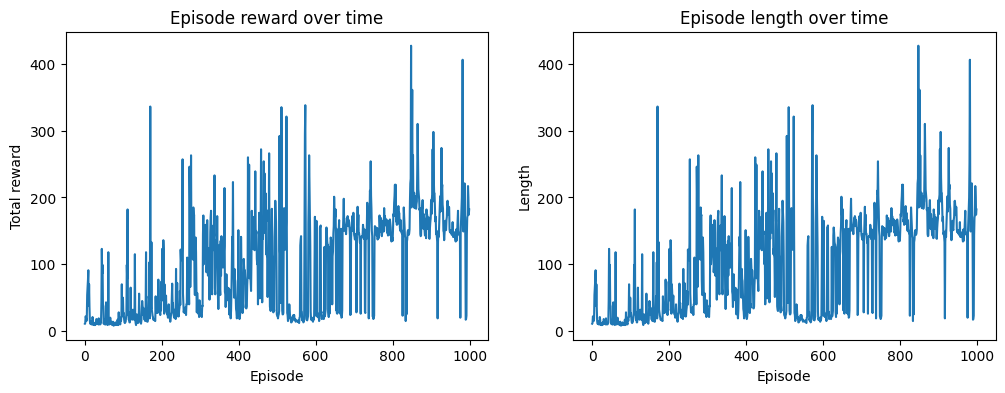

In [ ]:
agent.train()
agent.log()

In [ ]:
env = create_env("LunarLander-v2")
n_hidden = 64
lr = 0.001
net = DQN(env, n_hidden, lr=lr, optStep=.95)

gamma = 0.99
n_episode = 300
epsilon = 0.3
agent = Q_learning(env, net, gamma, n_episode, epsilon, batch_size = 512)

Available device:  cuda


  0%|          | 0/300 [00:00<?, ?it/s]

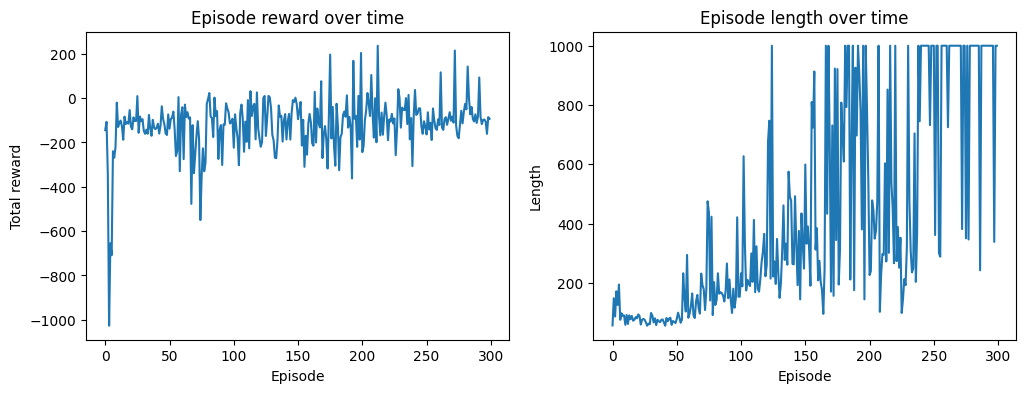

In [ ]:
agent.train()
agent.log()

In [ ]:
display_video(250)

## **Developing Dueling deep Q-Networks**

we are going to develop another advanced type of DQNs, Dueling DQNs (DDQNs). In particularly, we will see how the computation of the Q value is split into two parts in DDQNs.

In DDQNs, the Q value is computed with the following two functions:

<br>

$$
Q(s,a) = V(s) + A(s, a) - \frac{1}{|A|}\sum^{|A|}_{a=1}{A(s, a)}
$$

<br>

>$
V(s) \textit{ is the state-value function, calculating the value of being at state s}\\
A(s, a) \textit{ is the state-dependent action advantage function}
$

<br>

Advantage function, estimating how much better it is to take an action, $a$, rather than taking other actions at a state, $s$. By decoupling the value and advantage functions, we are able to accommodate the fact that our agent may not necessarily look at both the value and advantage at the same time during the learning process. In other words, the agent using DDQNs can efficiently optimize either or both functions as it prefers.

In [137]:
# class DeepNetwork(nn.Module):
#     """
#     A neural network for deep Q-learning with separate advantage and value streams.
#     """
#     def __init__(self, n_state, n_action, n_hidden=64):
#         super().__init__()
#         # Define the advantage stream
#         self.adv = nn.Sequential(
#             nn.Linear(n_state, n_hidden * 2),
#             nn.ReLU(),
#             nn.Linear(n_hidden * 2, n_hidden * 4),
#             nn.ReLU(),
#             nn.Linear(n_hidden * 4, n_hidden),
#             nn.ReLU(),
#             nn.Linear(n_hidden, n_action)  # Output advantage for each action
#         )
#         # Define the value stream
#         self.val = nn.Sequential(
#             nn.Linear(n_state, n_hidden * 2),
#             nn.ReLU(),
#             nn.Linear(n_hidden * 2, n_hidden * 4),
#             nn.ReLU(),
#             nn.Linear(n_hidden * 4, n_hidden),
#             nn.ReLU(),
#             nn.Linear(n_hidden, 1)  # Output a single scalar value
#         )

#     def forward(self, state):
#         """
#         Compute the Q-value using the advantage and value streams.
#         """
#         adv = self.adv(state)
#         val = self.val(state)
#         # Combine value and advantage with a normalization term
#         return val + adv - adv.mean()


class DeepNetwork(nn.Module):
    """
    A neural network for deep Q-learning with a shared head and separate
    advantage and value streams.
    """
    def __init__(self, n_state, n_action, n_hidden=64, normalize=True):
        super().__init__()
        # Shared head for feature extraction
        self.head = nn.Sequential(
            nn.Linear(n_state, n_hidden * 2),
            nn.LayerNorm(n_hidden * 2) if normalize else nn.Identity(),
            nn.ReLU(),
            nn.Linear(n_hidden * 2, n_hidden * 4),
            nn.LayerNorm(n_hidden * 4) if normalize else nn.Identity(),
            nn.ReLU()
        )
        # Advantage stream
        self.adv = nn.Sequential(
            nn.Linear(n_hidden * 4, n_hidden * 2),
            nn.LayerNorm(n_hidden * 2) if normalize else nn.Identity(),
            nn.ReLU(),
            nn.Linear(n_hidden * 2, n_hidden),
            nn.LayerNorm(n_hidden) if normalize else nn.Identity(),
            nn.ReLU(),
            nn.Linear(n_hidden, n_action)  # Output advantage for each action
        )
        # Value stream
        self.val = nn.Sequential(
            nn.Linear(n_hidden * 4, n_hidden * 2),
            nn.LayerNorm(n_hidden * 2) if normalize else nn.Identity(),
            nn.ReLU(),
            nn.Linear(n_hidden * 2, n_hidden),
            nn.LayerNorm(n_hidden) if normalize else nn.Identity(),
            nn.ReLU(),
            nn.Linear(n_hidden, 1)  # Output a single scalar value
        )

        # Initialize weights
        self._initialize_weights(self.head)
        self._initialize_weights(self.adv)
        self._initialize_weights(self.val)

    def _initialize_weights(self, network):
        """
        Initialize weights for Linear layers
        """
        for m in network:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0.1)  # Small positive bias to prevent dead neurons

    def forward(self, state):
        """
        Compute the Q-values by combining value and advantage streams.
        """
        out = self.head(state)  # Extract shared features
        adv = self.adv(out)  # Compute advantage
        val = self.val(out)  # Compute value
        # Combine value and advantage with a normalization term
        return val + adv - adv.mean()

In [142]:
class DQN():
    """
    A Deep Q-Network (DQN) implementation with a target network and prioritized replay.
    """
    def __init__(self, env, n_hidden=50, lr=0.05, optStep=50, optgamma=0.9, normalize=True):
        """
        Initialize the DQN agent.

        Args:
            env: The environment (OpenAI Gym compatible).
            n_hidden: Number of hidden units in the network.
            lr: Learning rate for the optimizer.
            optStep: Step size for learning rate decay.
        """
        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.n_action = env.action_space.n  # Number of possible actions
        self.n_state = env.observation_space.shape[0]  # Dimensionality of the state
        self.criterion = nn.SmoothL1Loss()  # Loss function (Huber loss)
        # Initialize the main model
        self.model = DeepNetwork(self.n_state, self.n_action, n_hidden, normalize).to(device)
        # Initialize the target model as a copy of the main model
        self.target_model = copy.deepcopy(self.model)
        # Optimizer for the main model
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)
        # Learning rate scheduler for the optimizer
        self.schedul = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=optStep, gamma=optgamma)

    def predict(self, state):
        """
        Predict Q-values for a given state using the main model.
        """
        with torch.no_grad():
            return self.model(state)

    def weighted_l1_loss(self, predictions, targets, weights):
        """
        Compute the weighted L1 loss.

        Args:
            predictions (Tensor): Predicted Q-values.
            targets (Tensor): Target Q-values.
            weights (Tensor): Importance-sampling weights.

        Returns:
            Tensor: Weighted L1 loss.
        """
        return torch.mean(weights * torch.abs(predictions - targets))  # Weighted absolute error

    def target_predict(self, state):
        """
        Predict Q-values for a given state using the target model.
        """
        with torch.no_grad():
            return self.target_model(state)

    def target_update(self):
        """
        Update the target model by copying the parameters of the main model.
        """
        self.target_model.load_state_dict(self.model.state_dict())

    def update(self, states, actions, q_value, weights):
        """
        Perform a gradient update for the model.

        Args:
            states (Tensor): Batch of states.
            actions (Tensor): Batch of actions taken.
            q_value (Tensor): Target Q-values.
            weights (Tensor): Importance-sampling weights.
        """
        # Get the predicted Q-values for the selected actions
        Q_pred = self.model(states).gather(1, torch.tensor(actions, dtype=torch.long).unsqueeze(1)).squeeze()
        # Compute the weighted L1 loss
        loss = self.weighted_l1_loss(Q_pred, q_value, weights)
        # Perform backpropagation and optimization
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [143]:
env = create_env("CartPole-v1", render_mode=None)
n_hidden = 64
lr = 0.002
net = DQN(env, n_hidden, lr=lr, optgamma=0.99, normalize=True)


gamma = 0.99
n_episode = 1000
epsilon = 0.3
agent = Q_learningPrioritized(
    env, net, gamma, n_episode, epsilon, epsilon_decay=0.997, batch_size = 512, random_play = 5000
)

>>> Pretrain model does not exist...


Filling replay buffer:   0%|          | 0/5000 [00:00<?, ?it/s]

>>> Available device: cuda - Highest possible score: 475.0


Episode:   0%|          | 0/1000 [00:00<?, ?it/s]

Best reward: 500.0


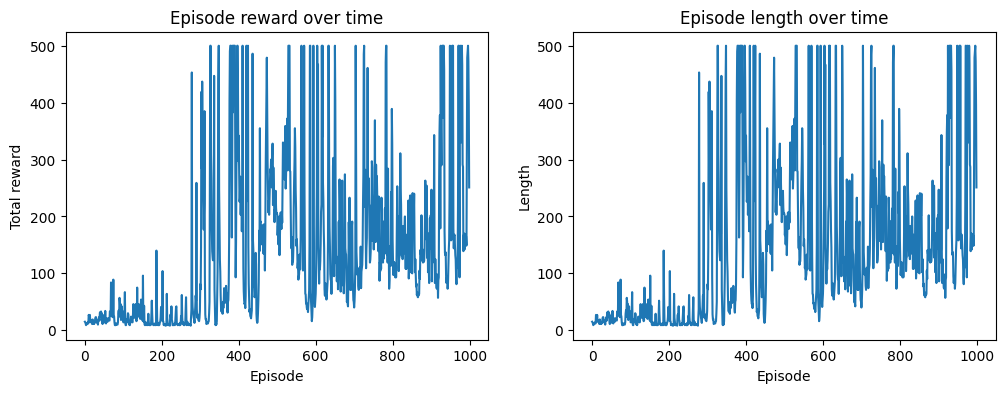

In [144]:
agent.train()
agent.log()

In [147]:
env = create_env("CartPole-v1", render_mode="rgb_array", record=True, eps_record=1)
agent = Q_learningPrioritized(
    env, net, gamma, n_episode, epsilon, epsilon_decay=0.999, batch_size = 512, random_play = 5000, model_path = "/content/model.pth"
)

agent.test_agent(3)

>>> Loading Q-network model...
Average reward: 500.00 - Average length of episodes: 500.0


In [148]:
display_video(2)

>>> Pretrain model does not exist...


Filling replay buffer:   0%|          | 0/5000 [00:00<?, ?it/s]

>>> Available device: cuda - Highest possible score: 200


Episode:   0%|          | 0/1000 [00:00<?, ?it/s]

Best reward: 270.3045709868496


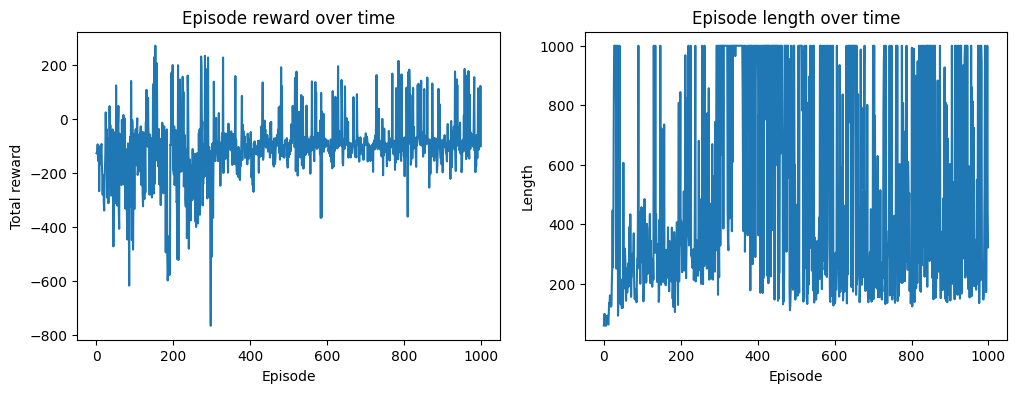

In [150]:
env = create_env("LunarLander-v3", render_mode=None)
n_hidden = 64
lr = 0.001
net = DQN(env, n_hidden, lr=lr, optgamma=0.99, normalize=True)


gamma = 0.99
n_episode = 1000
epsilon = 0.3
agent = Q_learningPrioritized(
    env, net, gamma, n_episode, epsilon, epsilon_decay=0.997, batch_size = 512, random_play = 5000
)

agent.train()
agent.log()

In [161]:
env = create_env("LunarLander-v3", render_mode="rgb_array", record=True, eps_record=1)
agent = Q_learningPrioritized(
    env, net, gamma, n_episode, epsilon, epsilon_decay=0.999, batch_size = 512, random_play = 5000, model_path = "/content/model.pth"
)

agent.test_agent(3)

>>> Loading Q-network model...
Average reward: -88.40 - Average length of episodes: 261.6666666666667


In [162]:
display_video(0)